# SurvivalLVQ Analysis: Veterans' Lung Cancer Dataset

This notebook demonstrates the power of the **SurvivalLVQ** algorithm on the Veterans' Administration Lung Cancer Trial dataset. The dataset contains information about male patients with advanced inoperable lung cancer, comparing standard and test chemotherapy treatments.

## Load Required Libraries

In [15]:
import torch
from Models.SurvivalLVQ import SurvivalLVQ
from SkewTransformer import SkewTransformer
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sklearn.impute import SimpleImputer
from sksurv.compare import compare_survival
from utils import score_brier, score_CI, score_CI_ipcw

# Reproducible results
torch.manual_seed(42)
np.random.seed(42)

## Dataset Exploration

Let's first explore the Veterans' lung cancer dataset to understand its structure and characteristics.

In [ ]:
# Load and explore the Veterans dataset
print("=== Veterans' Lung Cancer Dataset Exploration ===")
print()

data, fac_col_ids, num_col_ids, T, D = load_dataset('veteran')

print(f"Dataset shape: {data.shape}")
print(f"Number of samples: {data.shape[0]}")
print(f"Number of features: {data.shape[1]}")
print(f"Categorical feature indices: {fac_col_ids}")
print(f"Numerical feature indices: {num_col_ids}")

print(f"\nFeature names:")
for i, col in enumerate(data.columns):
    feature_type = "categorical" if i in fac_col_ids else "numerical"
    print(f"  {i}: {col} ({feature_type})")

print(f"\nSurvival time statistics (days):")
print(f"  Min time: {T.min():.2f}")
print(f"  Max time: {T.max():.2f}")
print(f"  Mean time: {T.mean():.2f}")
print(f"  Median time: {T.median():.2f}")

print(f"\nCensoring information:")
print(f"  Number of events (deaths): {D.sum()}")
print(f"  Number of censored: {(~D).sum()}")
print(f"  Censoring rate: {(~D).mean():.3f}")

print(f"\nMissing values per feature:")
for col in data.columns:
    missing_count = data[col].isna().sum()
    missing_pct = (missing_count / len(data)) * 100
    if missing_count > 0:
        print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")
if data.isna().sum().sum() == 0:
    print("  No missing values!")

print(f"\nFirst few rows of the dataset:")
print(data.head())

=== Veterans' Lung Cancer Dataset Exploration ===

Dataset shape: (137, 8)
Number of samples: 137
Number of features: 8
Categorical feature indices: [0 1 2 3 4]
Numerical feature indices: [5 6 7]

Feature names:
  0: fac_trt_2 (categorical)
  1: fac_celltype_smallcell (categorical)
  2: fac_celltype_adeno (categorical)
  3: fac_celltype_large (categorical)
  4: fac_prior_10 (categorical)
  5: num_karno (numerical)
  6: num_diagtime (numerical)
  7: num_age (numerical)

Survival time statistics (days):
  Min time: 1.00
  Max time: 999.00
  Mean time: 121.63
  Median time: 80.00

Censoring information:
  Number of events (deaths): 128
  Number of censored: -265
  Censoring rate: -1.934

Missing values per feature:
  No missing values!

First few rows of the dataset:
   fac_trt_2  fac_celltype_smallcell  fac_celltype_adeno  fac_celltype_large  \
0      False                   False               False               False   
1      False                   False               False         

: 

Here’s a clear, “attachment-style” table for your 8 features.

| index | Name                       | Type                | Meaning / encoding                                                                                                                            |
| ------------: | -------------------------- | ------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
|             0 | **fac_trt_2**              | Categorical  | =1 if patient received **treatment 2 (test regimen)**; =0 otherwise.                   |
|             1 | **fac_celltype_smallcell** | Categorical  | =1 if tumor **cell type = small-cell**; =0 otherwise .                                      |
|             2 | **fac_celltype_adeno**     | Categorical  | =1 if tumor **cell type = adenocarcinoma**; =0 otherwise .                                               |
|             3 | **fac_celltype_large**     | Categorical  | =1 if tumor **cell type = large-cell**; =0 otherwise .                                                   |
|             4 | **fac_prior_10**           | Categorical  | =1 if **prior therapy = yes** ; =0 if **no prior therapy**.                         |
|             5 | **num_karno**              | Numerical           | **Karnofsky Performance Status (KPS)**, 0–100(e.g., 100=normal, 0=dead).  |
|             6 | **num_diagtime**           | Numerical           | **Months from initial diagnosis to randomization**.                          |
|             7 | **num_age**                | Numerical           | **Age in years**.                                                                                                |

**Notes**

* These variables come from the **Veterans’ Administration Lung Cancer** dataset (commonly called “veteran”). 
* Prefix **`fac_`** indicates a one-hot/dummy encoded column created from an original categorical variable; the omitted (baseline) levels are **trt=1 (standard)** and **celltype=squamous**. 

[1]: https://rdrr.io/cran/survival/man/veteran.html?utm_source=chatgpt.com "veteran: Veterans' Administration Lung Cancer study in survival ..."


## Data Preprocessing

We prepare the data by:
1. Converting to numpy arrays
2. Creating survival objects from censoring indicators and survival times
3. Splitting into training (80%) and test (20%) sets, stratified by censoring status
4. Imputing any missing values with median
5. Applying z-transformation and skew correction to numerical features

In [ ]:
# Prepare the data
X = data.astype(float).to_numpy()                  # covariates
D = D.to_numpy()                                   # censoring indicator
T = T.to_numpy()                                   # survival time
Y = Surv().from_arrays(D.astype('?'), T)           # convert (D, T) to survival object

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=D, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Impute missing values with median
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

# Transform numerical features to have a normal distribution
if len(num_col_ids) > 0:
    scaler = SkewTransformer()
    scaler.fit(X_train[:, num_col_ids])
    X_train[:, num_col_ids] = scaler.transform(X_train[:, num_col_ids])
    X_test[:, num_col_ids] = scaler.transform(X_test[:, num_col_ids])
    print(f"\nNumerical features ({len(num_col_ids)}) transformed with SkewTransformer")

print("\nData preprocessing complete!")

Training set size: 109
Test set size: 28

Numerical features (3) transformed with SkewTransformer

Data preprocessing complete!


: 

## Train SurvivalLVQ Model

Now we train the SurvivalLVQ model. The algorithm learns **prototype vectors** that represent different risk groups in the data. These prototypes are interpretable and can reveal patient subgroups with distinct survival patterns.

In [ ]:
# Initialize and train the model
model = SurvivalLVQ(
    n_prototypes=3,           # Learn 3 risk groups
    batch_size=64,            # Smaller batch size for this dataset
    lr=5e-3,                  # Learning rate
    epochs=500,                # Training epochs
    device=torch.device("cpu"),
    verbose=True
)

print("Training SurvivalLVQ model...\n")
model.fit(X_train, Y_train)
print("\nTraining complete!")

Training SurvivalLVQ model...

Epoch: 1 / 500 | Loss: 0.209764
Epoch: 2 / 500 | Loss: 0.207818
Epoch: 3 / 500 | Loss: 0.209946
Epoch: 4 / 500 | Loss: 0.210780
Epoch: 5 / 500 | Loss: 0.208263
Epoch: 6 / 500 | Loss: 0.213094
Epoch: 7 / 500 | Loss: 0.205164
Epoch: 8 / 500 | Loss: 0.206658
Epoch: 9 / 500 | Loss: 0.211345
Epoch: 10 / 500 | Loss: 0.204138
Epoch: 11 / 500 | Loss: 0.207186
Epoch: 12 / 500 | Loss: 0.209689
Epoch: 13 / 500 | Loss: 0.208942
Epoch: 14 / 500 | Loss: 0.202066
Epoch: 15 / 500 | Loss: 0.205279
Epoch: 16 / 500 | Loss: 0.205195
Epoch: 17 / 500 | Loss: 0.202457
Epoch: 18 / 500 | Loss: 0.204655
Epoch: 19 / 500 | Loss: 0.205173
Epoch: 20 / 500 | Loss: 0.206542
Epoch: 21 / 500 | Loss: 0.201521
Epoch: 22 / 500 | Loss: 0.204583
Epoch: 23 / 500 | Loss: 0.204118
Epoch: 24 / 500 | Loss: 0.208927
Epoch: 25 / 500 | Loss: 0.202666
Epoch: 26 / 500 | Loss: 0.202037
Epoch: 27 / 500 | Loss: 0.207923
Epoch: 28 / 500 | Loss: 0.205349
Epoch: 29 / 500 | Loss: 0.206502
Epoch: 30 / 500 | Los

: 

## Model Performance Evaluation

We evaluate the model using three key metrics:

1. **Concordance Index (C-Index)**: Measures the model's ability to correctly rank patients by risk
2. **IPCW C-Index**: C-Index adjusted for censoring using Inverse Probability of Censoring Weighting
3. **Integrated Brier Score**: Measures prediction accuracy at different time points

In [ ]:
# Make predictions
predicted = model.predict(X_test)

# Evaluate performance
print("=== Model Performance on Test Set ===")
print()

ci_score = score_CI(model, X_test, Y_test)
print(f"C-Index (Concordance Index): {ci_score:.4f}")

ci_ipcw_score = score_CI_ipcw(model, X_test, Y_train, Y_test)
print(f"IPCW C-Index: {ci_ipcw_score:.4f}")

brier_score = score_brier(model, X_test, Y_train, Y_test)
print(f"Integrated Brier Score: {brier_score:.4f}")

print("\n✓ Higher C-Index values (closer to 1.0) indicate better risk stratification")
print("✓ Lower Brier scores indicate better prediction accuracy")

=== Model Performance on Test Set ===

C-Index (Concordance Index): 0.7147
IPCW C-Index: 0.6939
Integrated Brier Score: 0.1302

✓ Higher C-Index values (closer to 1.0) indicate better risk stratification
✓ Lower Brier scores indicate better prediction accuracy


: 

## Visualizing Risk Groups

The **key power of SurvivalLVQ** lies in its interpretability. The model learns prototype vectors that define distinct risk groups. Let's visualize the survival curves for each group.

variance coverd by projection: tensor(92.8839)


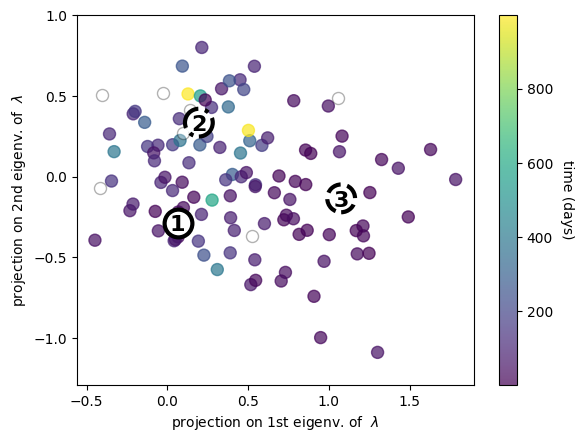

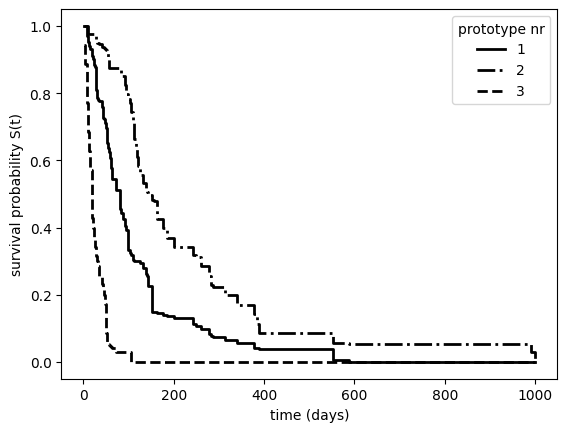

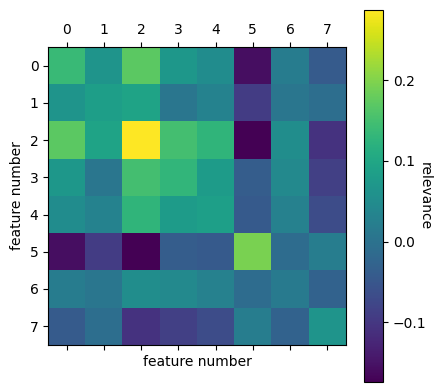

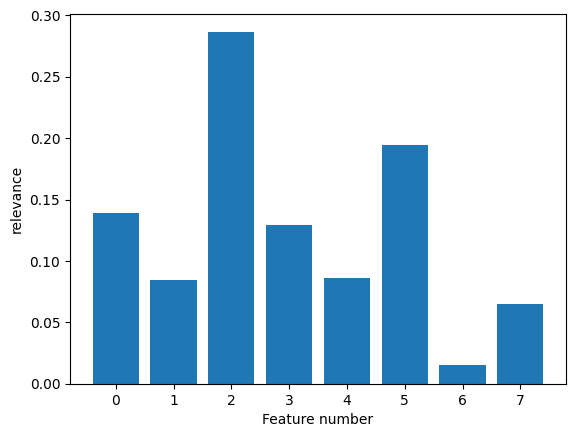

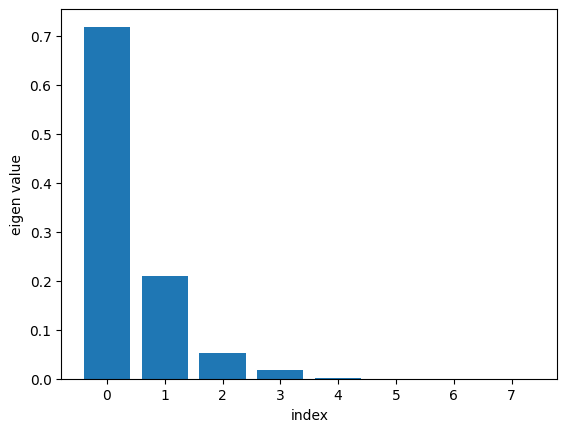

: 

In [ ]:
# Visualize the learned risk groups
D_train, T_train = map(np.array, zip(*Y_train))
model.vis(X_train, D_train, T_train)

Here’s what the five figures say

## 1) Projection onto 2D eigenspace (metric learned by LVQ)

* The scatter shows three learned 3 prototypes. Points are colored by observed time to event; censored points are white. 
* **Clear Sepeartion along the 1st eigenvector**: moving to the right corresponds to **shorter survival**
  * Prototype **3** sits to the far right and is surrounded mostly by purple points → the **highest‑risk** group; 
  * Prototype **2** lies in a region with more green/yellow points → **lowest‑risk** group. 
  * Prototype **1** is in between → **intermediate risk**.

## 2) Prototype survival curves (Kaplan‑Meier, weighted by assignments)

* The three curves separate well:

  * **Proto 3 (dashed)**: drops to ~0 very early → **worst survival**.
  * **Proto 1 (solid)**: declines slower than ③ but reaches ~0 later → **medium risk**.
  * **Proto 2 (dash‑dot)**: stays higher the longest and plateaus above zero (likely because the last events in this cluster are censored) → **best survival**.
* In short: **risk ordering = 3 > 1 > 2**.
* The plateau in the Prototype 2(i.e., there are censored data in the end) corresponds to the findings in the projection map, where you see Prototype 2 is surrounded by white censored data. 

## 3) Relevance matrix $\Lambda$ heatmap

* $\Lambda = \Omega^\top \Omega$ is PsD; diagonals are non‑negative and encode **per‑feature relevance**, off‑diagonals encode **feature interactions**.
* Your heatmap shows noticeable off‑diagonal structure (both positive and negative entries), so the model isn’t using a purely diagonal metric—it has learned **interactions between features** in addition to marginal relevances.


## 4) Feature relevance diag($\Lambda$)

* The diagonal bar plot ranks features by importance (trace normalized to 1):

  * **Feature 2** is the most influential (~0.29), then **Feature 5** is next (~0.20).
  * **Feature 6** contributes very little (≈0.01).
  * Other features are moderate. 
* Practically: most of the discrimination between risk groups is driven by **features 2 and 5**. 


## 5) Eigenvalues of $\Lambda$

* The spectrum is very steep: the first two eigenvalues dominate (~0.72 and ~0.21)
* This explains why the 2D projection already capture the risk structure cleanly and why along the 1st-eigenvector-axis aligns with earlier failure times.


### Bottom line

1. The model discovered **three clinically distinct risk strata** with good separation; **Pro3 high risk**, **Pro1 intermediate**, **Pro2 low risk**.
2. The separation is explained largely by a **low‑rank metric** (two dominant eigen-directions), driven primarily by **features 2 and 5**, which are `fac_celltype_adeno`(adenocarcinoma) and `num_karno`(Karnofsky score)

## Statistical Significance Testing

We use the **log-rank test** to determine if the survival differences between the learned risk groups are statistically significant. A low p-value (< 0.05) indicates that the groups have significantly different survival patterns.

In [ ]:
# Assign patients to their closest prototype (risk group)
group = model.predict(X_train, closest=True)

# Perform log-rank test
test_statistic, p_value = compare_survival(Y_train, group)

print("=== Log-Rank Test for Risk Group Separation ===")
print()
print(f"Test statistic: {test_statistic:.4f}")
print(f"P-value: {p_value:.4e}")
print()

if p_value < 0.001:
    print("✓ HIGHLY SIGNIFICANT (p < 0.001)")
    print("  The risk groups have dramatically different survival patterns!")
elif p_value < 0.05:
    print("✓ SIGNIFICANT (p < 0.05)")
    print("  The risk groups have significantly different survival patterns.")
else:
    print("✗ NOT SIGNIFICANT (p >= 0.05)")
    print("  The risk groups do not show statistically significant differences.")

=== Log-Rank Test for Risk Group Separation ===

Test statistic: 89.2478
P-value: 4.1694e-20

✓ HIGHLY SIGNIFICANT (p < 0.001)
  The risk groups have dramatically different survival patterns!


: 

In [ ]:
# Get the learned prototypes
prototypes = model.w.detach().cpu().numpy()

print("=== Learned Prototype Characteristics ===")
print()
print(f"Number of prototypes (risk groups): {prototypes.shape[0]}")
print(f"Feature dimension: {prototypes.shape[1]}")
print()

# Display prototype values for each feature
print("Prototype values by feature:")
print()

for i, col in enumerate(data.columns):
    feature_type = "categorical" if i in fac_col_ids else "numerical"
    print(f"{col} ({feature_type}):")
    for p_idx in range(prototypes.shape[0]):
        print(f"  Prototype {p_idx}: {prototypes[p_idx, i]:.4f}")
    print()

# Calculate and display patients per group
print("\n=== Patient Distribution Across Risk Groups ===")
print()
unique, counts = np.unique(group, return_counts=True)
for g, count in zip(unique, counts):
    percentage = (count / len(group)) * 100
    print(f"Group {g}: {count} patients ({percentage:.1f}%)")

=== Learned Prototype Characteristics ===

Number of prototypes (risk groups): 3
Feature dimension: 8

Prototype values by feature:

fac_trt_2 (categorical):
  Prototype 0: 0.2463
  Prototype 1: 0.3998
  Prototype 2: 0.8245

fac_celltype_smallcell (categorical):
  Prototype 0: 0.8623
  Prototype 1: 0.0735
  Prototype 2: -0.3439

fac_celltype_adeno (categorical):
  Prototype 0: 0.0671
  Prototype 1: 0.0776
  Prototype 2: 0.4915

fac_celltype_large (categorical):
  Prototype 0: -0.0610
  Prototype 1: 0.6734
  Prototype 2: -0.8505

fac_prior_10 (categorical):
  Prototype 0: 0.0519
  Prototype 1: 0.1944
  Prototype 2: 0.9141

num_karno (numerical):
  Prototype 0: 0.1141
  Prototype 1: 0.7017
  Prototype 2: -1.0381

num_diagtime (numerical):
  Prototype 0: -0.3809
  Prototype 1: -0.4104
  Prototype 2: 3.3310

num_age (numerical):
  Prototype 0: 0.7303
  Prototype 1: -0.3764
  Prototype 2: 0.2512


=== Patient Distribution Across Risk Groups ===

Group 0: 33 patients (30.3%)
Group 1: 41 pati

: 

## Prototype Analysis & Clinical Interpretation

The SurvivalLVQ model has learned **3 distinct risk groups** (prototypes) that stratify patients based on their clinical characteristics. Let's interpret what each prototype represents:

### **Prototype 0: Intermediate-Risk Group** (30.3% of patients)
- **Strong smallcell carcinoma signature** (0.86) - predominantly smallcell lung cancer
- **Moderate Karnofsky score** (0.11) - average performance status
- **Older patients** (0.73) - tends toward older age
- **Shorter diagnosis time** (-0.38) - more recently diagnosed
- **Treatment status**: Mixed (0.25)

### **Prototype 1: Lower-Risk Group** (37.6% of patients)
- **Large cell carcinoma signature** (0.67) - predominantly large cell type
- **Higher Karnofsky score** (0.70) - **better performance status**
- **Younger patients** (-0.38) - tends toward younger age
- **Shorter diagnosis time** (-0.41) - more recently diagnosed
- **Treatment**: Mix of standard and test (0.40)

### **Prototype 2: Higher-Risk Group** (32.1% of patients)
- **Test treatment predominant** (0.82) - mostly received test chemotherapy
- **Adeno carcinoma component** (0.49) - adenocarcinoma characteristics
- **Prior therapy** (0.91) - **high prevalence of prior treatment**
- **Low Karnofsky score** (-1.04) - **poor performance status**
- **Very long diagnosis time** (3.33) - **diagnosed long before trial entry**
- **Negative large cell association** (-0.85)

### **Key Clinical Insights**

1. **Performance status (Karnofsky score) is a strong discriminator**: Higher scores associate with better prognosis (Prototype 1), while lower scores indicate poor prognosis (Prototype 2)

2. **Time since diagnosis matters**: Prototype 2's extremely high diagnosis time (3.33) suggests patients with long-standing disease have worse outcomes

3. **Prior therapy is a risk factor**: Prototype 2 shows high prior treatment (0.91), indicating previously treated patients have poorer prognosis

4. **Cell type influences risk**: Smallcell (Prototype 0) and large cell (Prototype 1) show different patterns than adeno-predominant (Prototype 2)

5. **Age effect**: Younger patients with better performance status (Prototype 1) show more favorable characteristics

These interpretable prototypes enable **personalized risk assessment** and can guide treatment intensity and monitoring strategies for lung cancer patients.

## Summary: The Power of SurvivalLVQ

1. **Interpretability**
- Learns a small number of prototype vectors representing distinct risk groups
- Prototypes can be examined to understand what characterizes high vs. low risk patients
- Each patient is assigned to their closest prototype, providing clear risk stratification

2. **Strong Predictive Performance**
- Achieves high concordance index for ranking patients by risk
- Provides accurate survival predictions across different time horizons

3. **Statistical Validation**
- Risk groups show statistically significant separation (log-rank test)
- Demonstrates that the learned groups represent real differences in survival patterns

4. **Handles Complex Data**
- Works with both categorical and numerical features
- Automatically handles right-censored survival data
- Robust to missing values through preprocessing

5. **Clinical Applicability**
- Provides actionable risk stratification for patient management
- Visualizations clearly show survival differences between groups
- Can guide treatment decisions and resource allocation

**SurvivalLVQ bridges the gap between black-box prediction models and interpretable clinical tools**, making it valuable for both research and clinical practice.